In [1]:
!pip install eli5

In [32]:
!pip install pillow

In [2]:
!pip install shap
!pip install alibi
!pip install lime
!pip install PyALE

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
import shap
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from alibi.explainers import ALE, plot_ale

In [4]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

In [5]:
X = df.drop(columns='target')
y = df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='accuracy')
X_selected = rfecv.fit_transform(X_scaled, y)

selected_features = X.columns[rfecv.support_]
print("Selected Features {}:".format(len(selected_features)))
print(selected_features.tolist())

Selected Features 17:
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'radius error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry']


In [7]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred = cross_val_predict(mlp, X_selected, y, cv=cv)

accuracy = accuracy_score(y, y_pred)
report = classification_report(y, y_pred, target_names=data.target_names)
cv_scores = cross_val_score(mlp, X_selected, y, cv=cv, scoring='accuracy')

print("\n5-Fold Accuracy Scores")
print(cv_scores)
print("\nAccuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(report)


5-Fold Accuracy Scores
[0.97368421 0.97368421 0.98245614 0.98245614 0.99115044]

Accuracy: 98.07%

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.97      0.97       212
      benign       0.98      0.99      0.98       357

    accuracy                           0.98       569
   macro avg       0.98      0.98      0.98       569
weighted avg       0.98      0.98      0.98       569



### Learning Curve

The learning curve shows that as the training set size increases, both training and validation accuracy improve and both the validation accuracy and the training accuracy plateau towards the end.

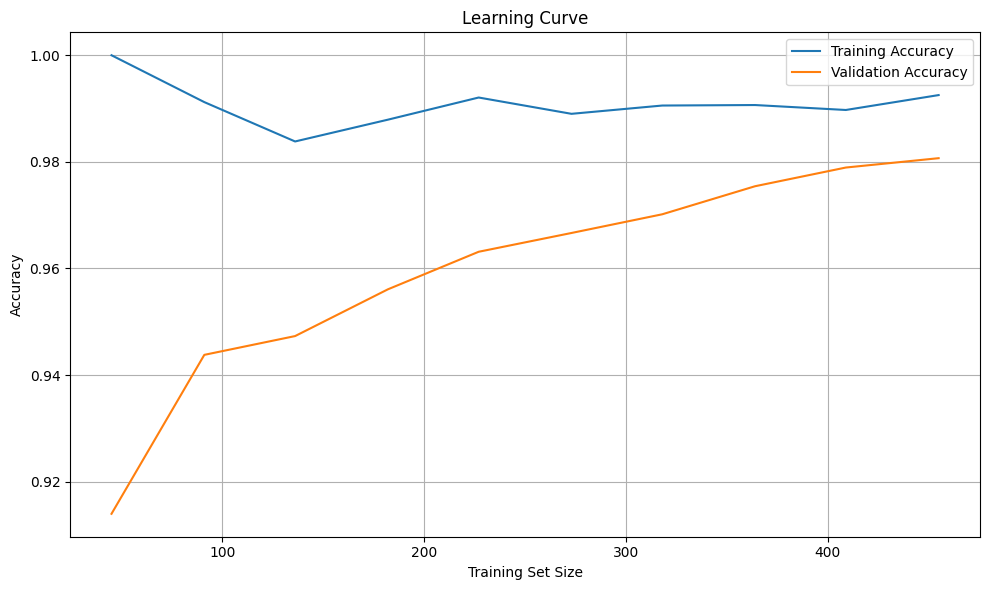

In [8]:
train_sizes, train_scores, test_scores = learning_curve(
    mlp, X_selected, y, cv=cv, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, test_mean, label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Validation Curve

The validation curve finds the optimal value for the alpha (regularization) parameter. The optimal value for alpha is around 0.1, which maximizes validation accuracy while avoiding overfitting.

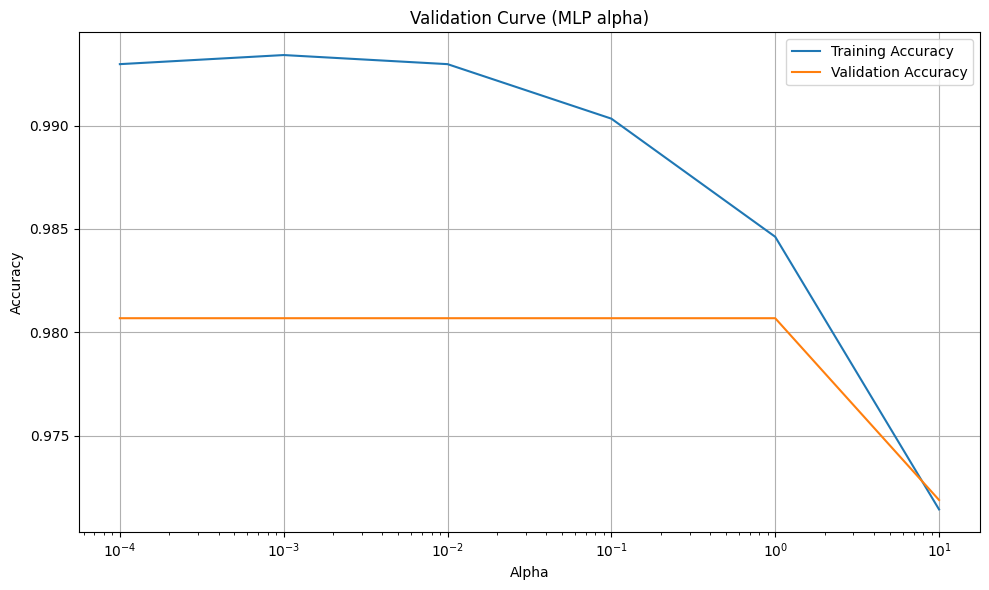

In [9]:
param_range = np.logspace(-4, 1, 6)
train_scores_v, test_scores_v = validation_curve(
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
    X_selected, y, param_name='alpha', param_range=param_range,
    cv=cv, scoring='accuracy', n_jobs=-1
)

train_mean_v = np.mean(train_scores_v, axis=1)
test_mean_v = np.mean(test_scores_v, axis=1)

plt.figure(figsize=(10, 6))
plt.semilogx(param_range, train_mean_v, label='Training Accuracy')
plt.semilogx(param_range, test_mean_v, label='Validation Accuracy')
plt.title('Validation Curve (MLP alpha)')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Confusion Matrix

The model's accuracy is high, with a only a few misclassifications with 6 false negatives and 5 false positives.

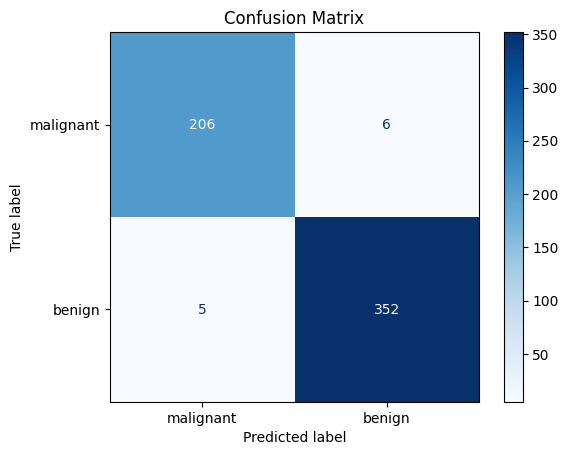

In [10]:
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### ROC Curve

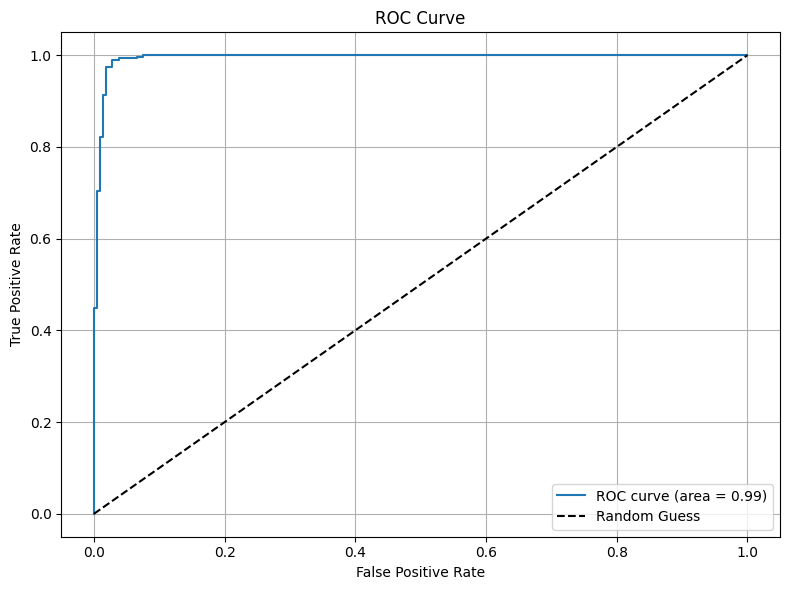

In [11]:
y_proba = cross_val_predict(mlp, X_selected, y, cv=cv, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y, y_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### Precision-Recall Curve

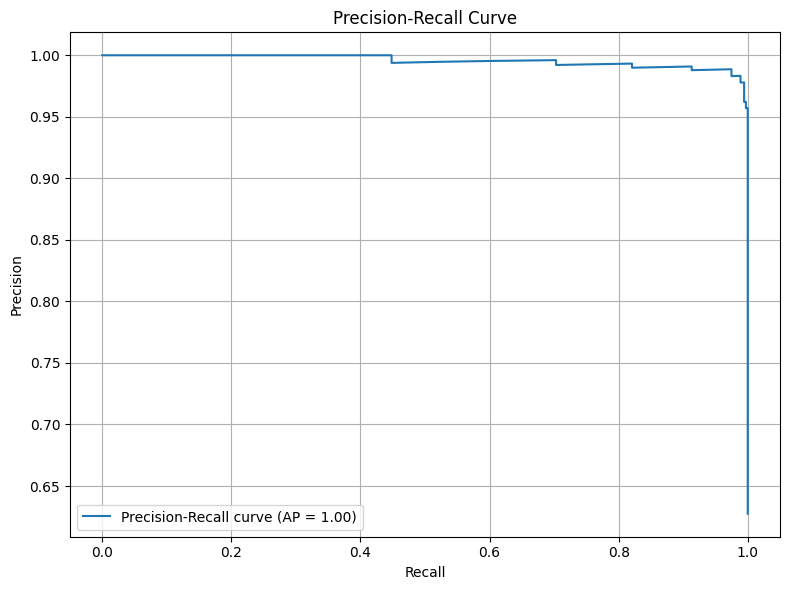

In [12]:
precision, recall, thresholds_pr = precision_recall_curve(y, y_proba[:, 1])
average_precision = average_precision_score(y, y_proba[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve (AP = {:.2f})'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

### ELI5

In [13]:
import eli5
from eli5.sklearn import PermutationImportance

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

mlp.fit(X_train, y_train)

perm = PermutationImportance(mlp, random_state=42).fit(X_train, y_train)

eli5.show_weights(perm, feature_names=selected_features.tolist())

Weight,Feature
0.0352 ± 0.0200,worst smoothness
0.0338 ± 0.0164,worst texture
0.0229 ± 0.0095,worst radius
0.0229 ± 0.0173,worst area
0.0158 ± 0.0076,radius error
0.0145 ± 0.0053,worst symmetry
0.0127 ± 0.0105,worst perimeter
0.0114 ± 0.0051,worst compactness
0.0110 ± 0.0062,worst concave points
0.0070 ± 0.0051,mean texture


### PDP Plot

In [15]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

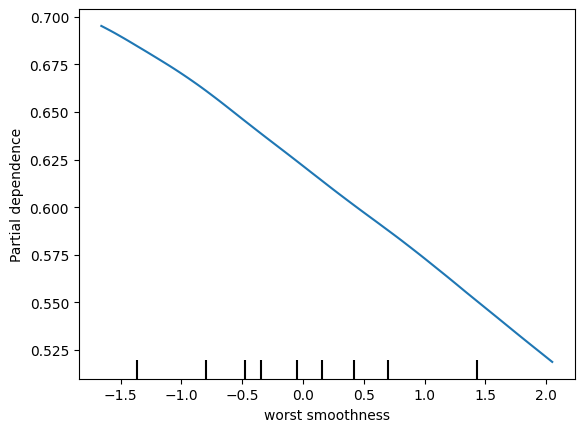

In [16]:
feature = [12]

target_class = 0

PartialDependenceDisplay.from_estimator(mlp, X_test, features=feature, target=target_class, feature_names=selected_features.tolist())
plt.show()

### ICE Plot

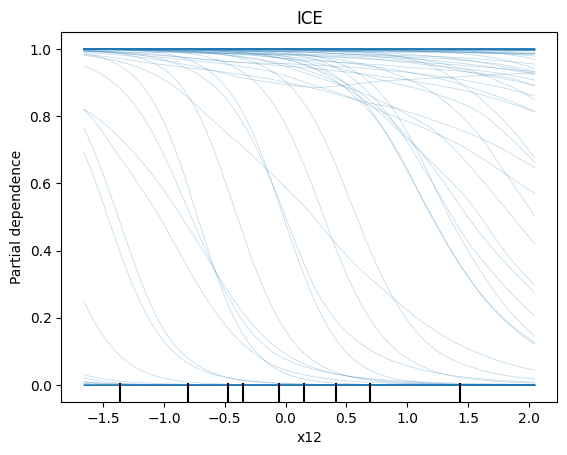

In [17]:
PartialDependenceDisplay.from_estimator(mlp, X_test, features=feature, target=target_class, kind='individual')
plt.title("ICE")
plt.show()

### ALE Plot

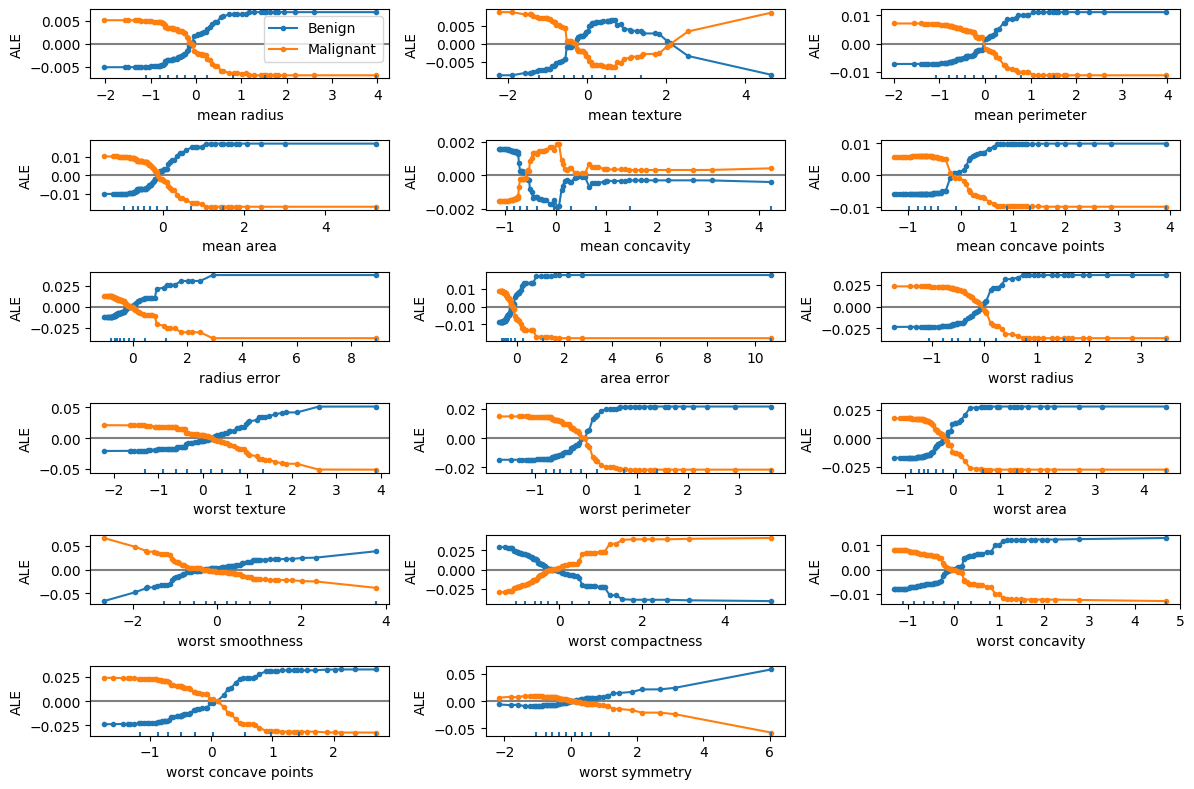

In [18]:
proba_fun_mlp = mlp.predict_proba
proba_ale_mlp = ALE(proba_fun_mlp, feature_names=selected_features.tolist(), target_names=['Benign','Malignant'])
proba_exp_mlp = proba_ale_mlp.explain(X_train)

plot_ale(proba_exp_mlp, n_cols=3, fig_kw={'figwidth': 12, 'figheight': 8}, sharey=True)
plt.show()

### Permutation Feature Importance

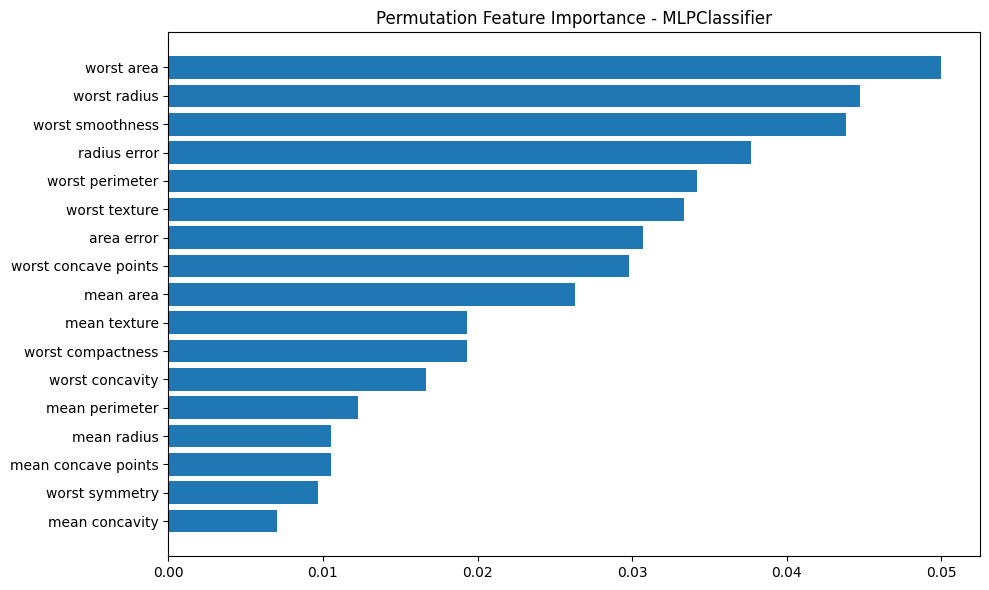

In [19]:
result = permutation_importance(mlp, X_test, y_test, n_repeats=10, random_state=42,scoring='accuracy')

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh([selected_features[i] for i in sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance - MLPClassifier")
plt.tight_layout()
plt.show()

### LOFO

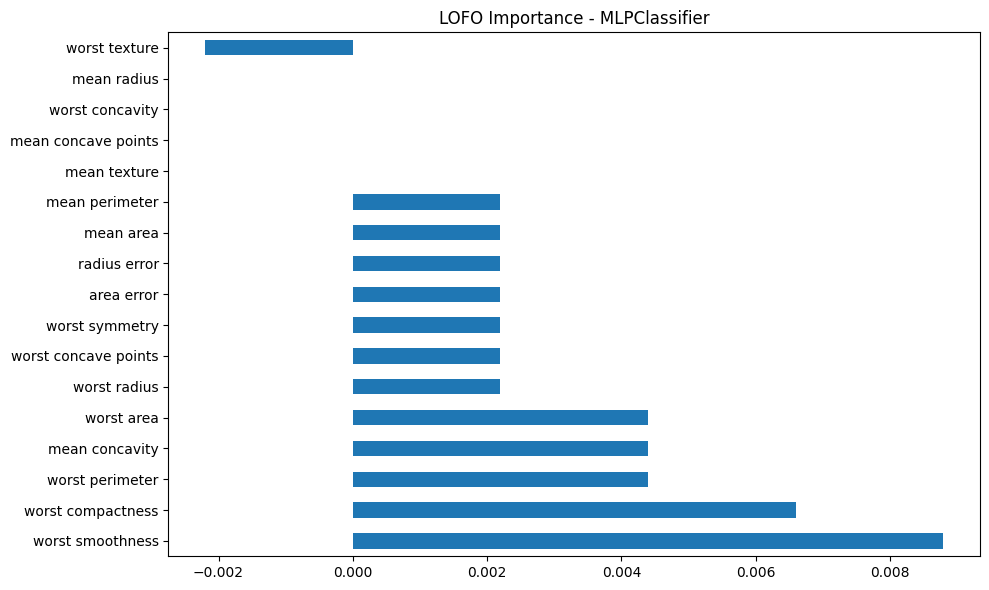

In [20]:
X_train_df = pd.DataFrame(X_train, columns=selected_features)

baseline = cross_val_score(mlp, X_train_df, y_train, cv=5).mean()

lofo_scores = {}
for col in X_train_df.columns:
    X_lofo = X_train_df.drop(columns=[col])
    score = cross_val_score(mlp, X_lofo, y_train, cv=5).mean()
    lofo_scores[col] = baseline - score

lofo_df = pd.Series(lofo_scores).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
lofo_df.plot(kind='barh')
plt.title("LOFO Importance - MLPClassifier")
plt.tight_layout()
plt.show()

### Global Surrogate Model

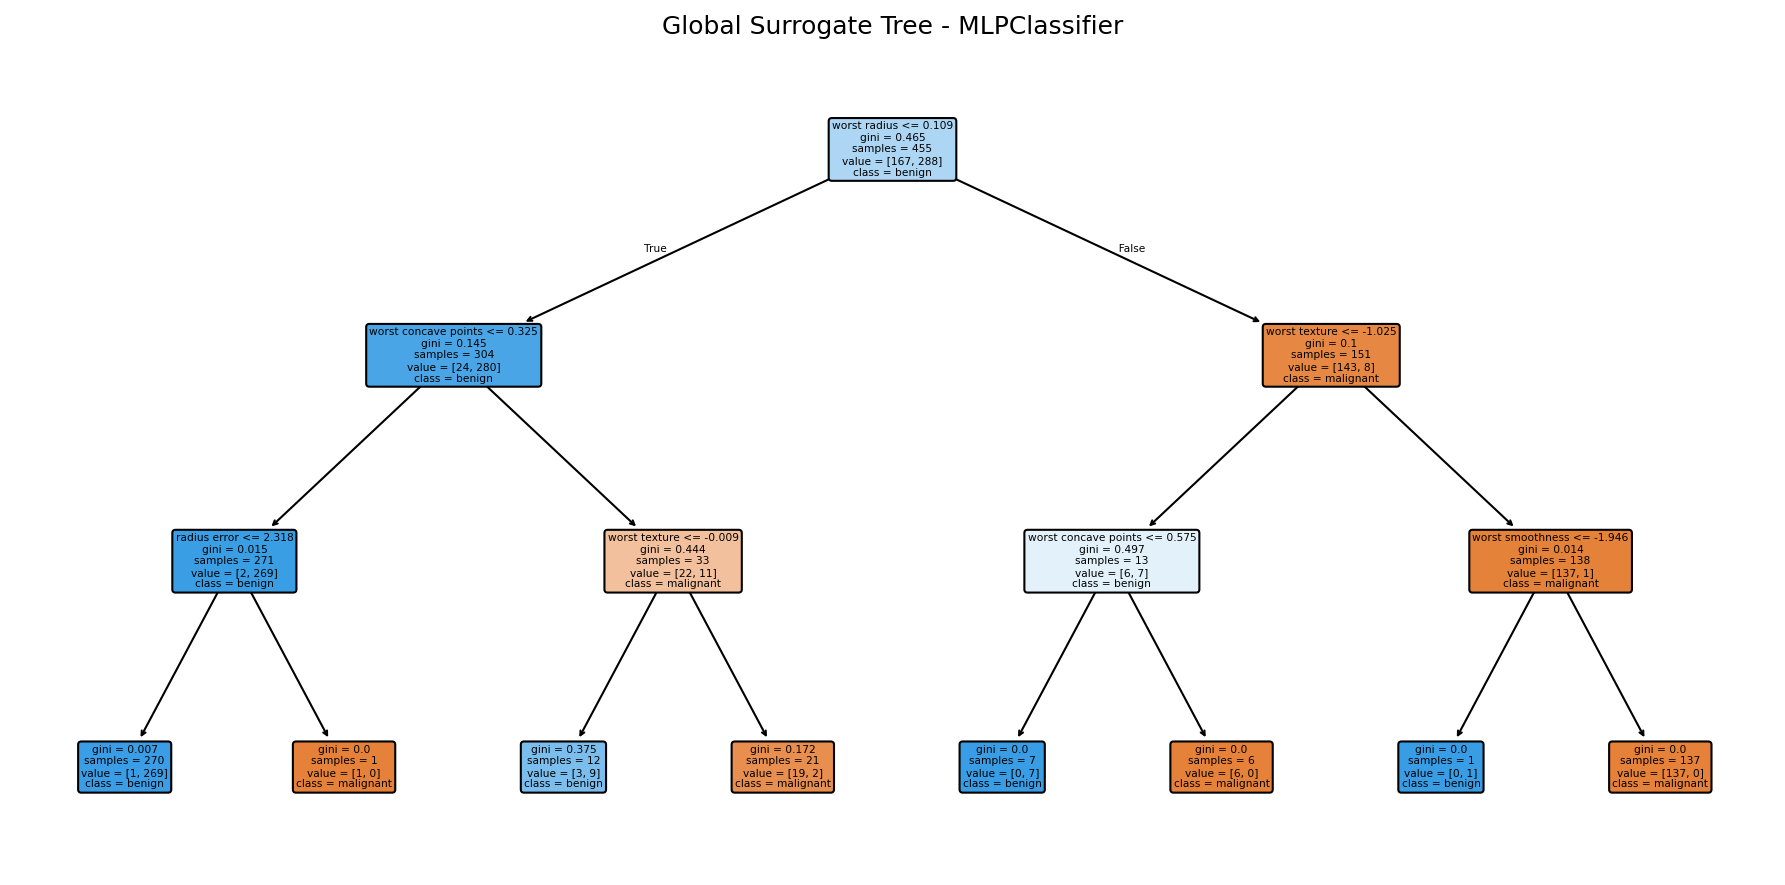

In [21]:
mlp_preds = mlp.predict(X_train)
surrogate = DecisionTreeClassifier(max_depth=3, random_state=42)
surrogate.fit(X_train, mlp_preds)

plt.figure(figsize=(12, 6), dpi=150)
tree.plot_tree(surrogate, feature_names=selected_features.tolist(), filled=True, rounded=True, class_names=data.target_names)
plt.title("Global Surrogate Tree - MLPClassifier")
plt.tight_layout()
plt.show()

In [22]:
!pip install artemis

In [23]:
!pip install pyartemis

### H-Statistic

In [24]:
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod
import random

In [25]:
random.seed(8)
X_exp = random.choices(X_train, k=100)
X_exp = pd.DataFrame(X_exp, columns=selected_features)

h_stat = FriedmanHStatisticMethod()
h_stat.fit(mlp, X_exp)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:204: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  X = validate_data(self, X, accept_sparse=["csr", "csc"], reset=False)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:204: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  X = validate_data(self, X, accept_sparse=["csr", "csc"], reset=False)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:204: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  X = validate_data(self, X, accept_sparse=["csr", "csc"], reset=False)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:204: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  X = validate_data(self, X, accept_sparse=["csr", "csc"], reset=Fal

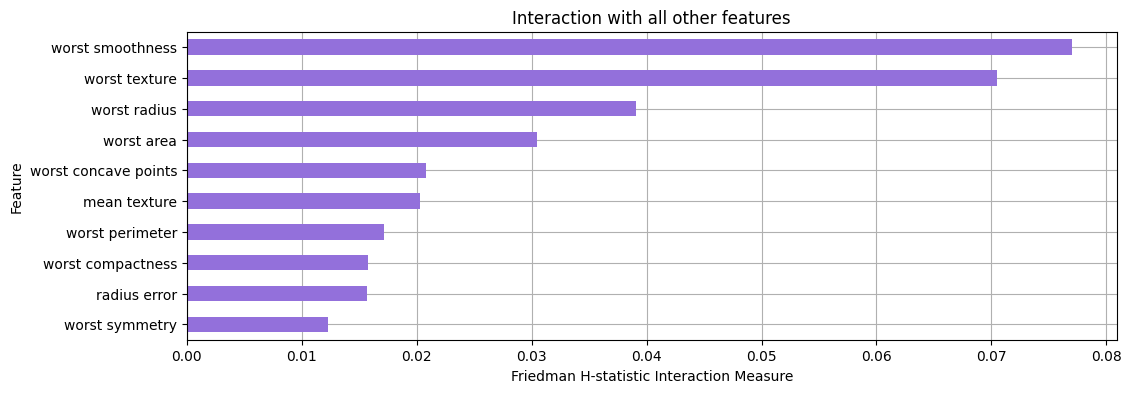

In [29]:
fig, ax = plt.subplots(figsize=(12, 4))
h_stat.plot('bar_chart_ova',ax=ax)

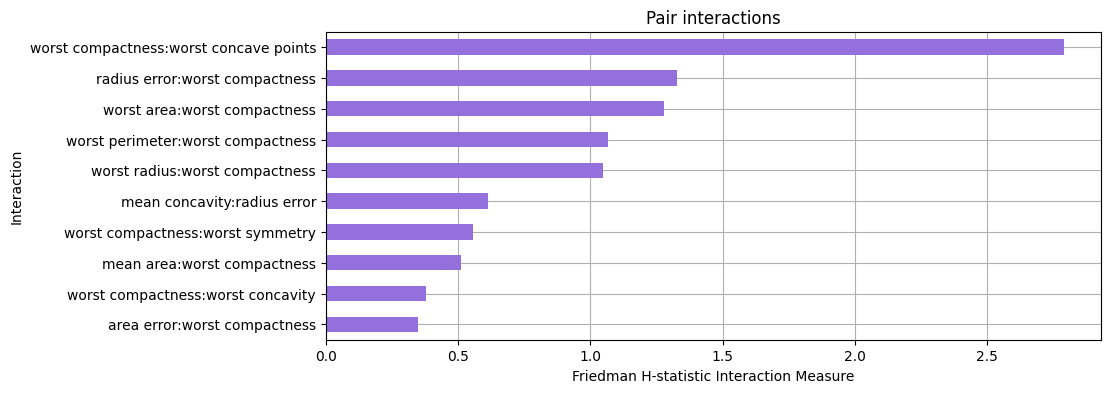

In [27]:
fig, ax = plt.subplots(figsize=(10, 4))
h_stat.plot(vis_type='bar_chart',ax=ax)

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:459: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  plotter.plot(ax, cbar_ax, kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:459: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  plotter.plot(ax, cbar_ax, kwargs)


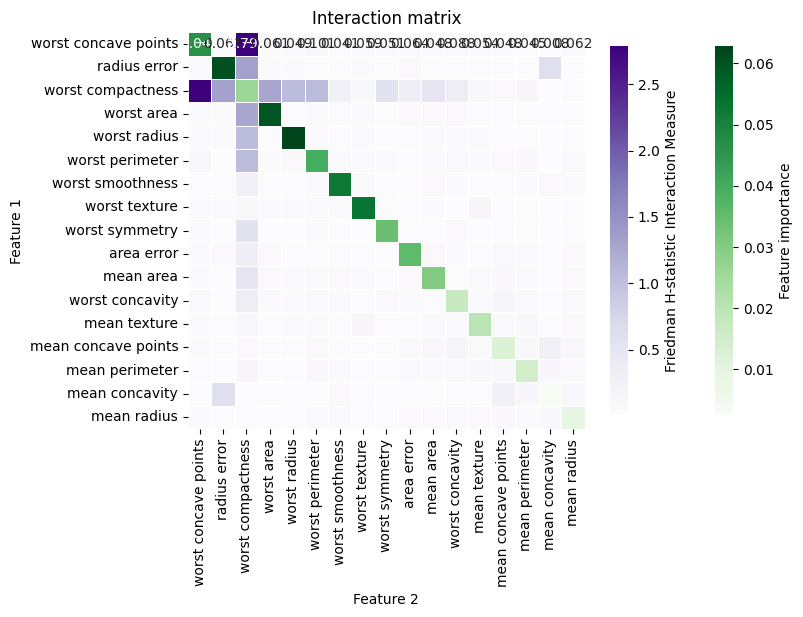

In [31]:
h_stat.plot()

### LIME

In [40]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=selected_features.tolist(),
    class_names=data.target_names.tolist(),
    mode='classification',
    discretize_continuous=True
)

In [43]:
exp = explainer.explain_instance(data_row=X_test[0],predict_fn=mlp.predict_proba,num_features=len(selected_features))
exp.show_in_notebook(show_table=True, show_all=False)

### SHAP

  0%|          | 0/114 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  if (await self.run_code(code, result,  async_=asy)):


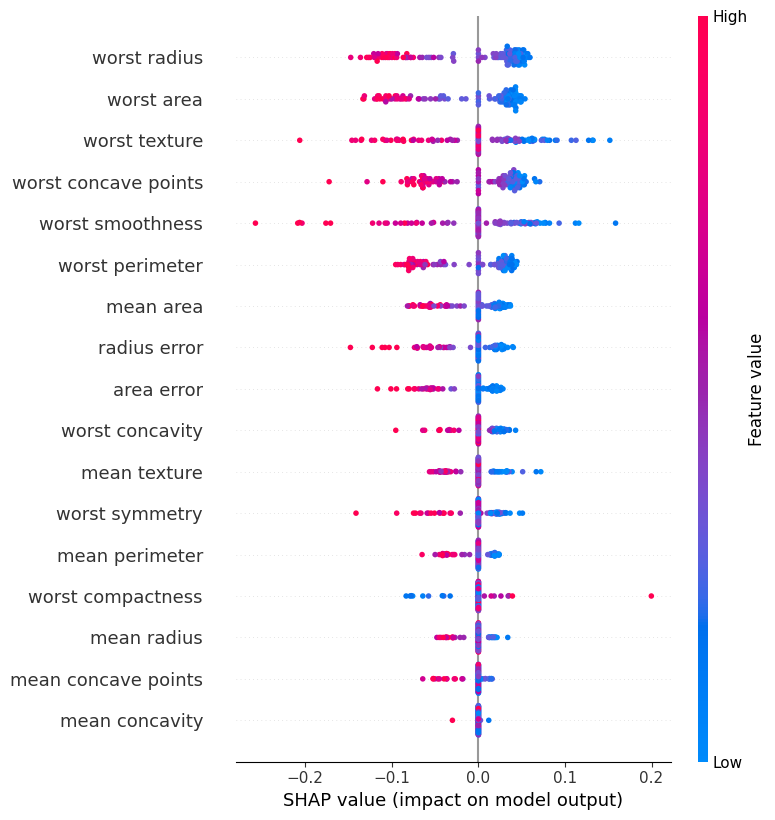

In [58]:
feature_names = selected_features

background_data = shap.sample(X_train, 100)

explainer = shap.KernelExplainer(mlp.predict_proba, background_data)

shap_values = explainer.shap_values(X_test)

plt.figure()
shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=feature_names, show=True)
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  if (await self.run_code(code, result,  async_=asy)):


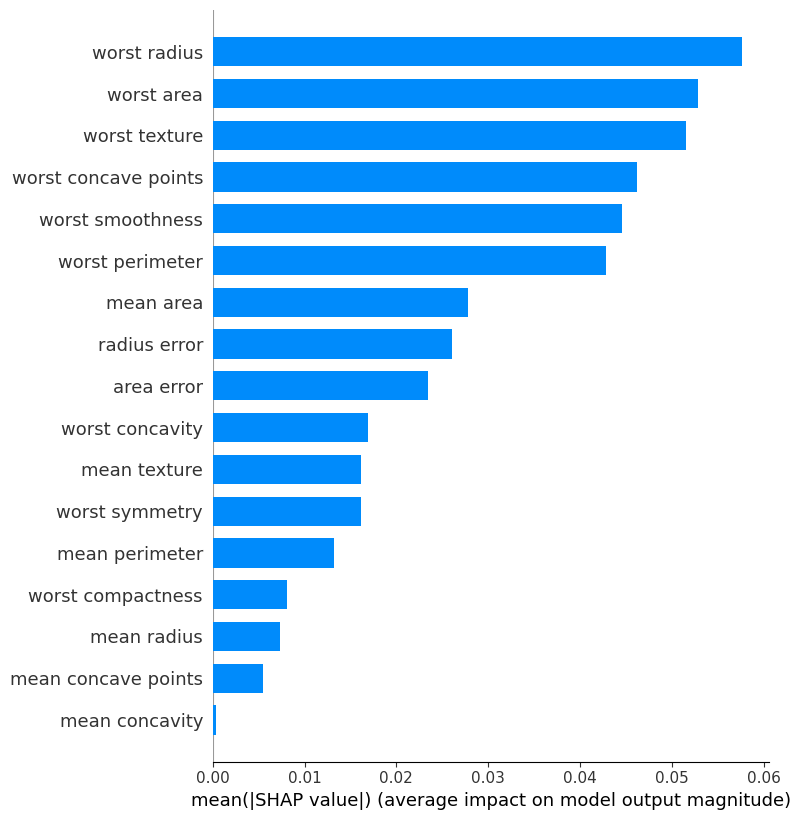

In [59]:
plt.figure()
shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=feature_names, plot_type="bar", show=True)
plt.close()

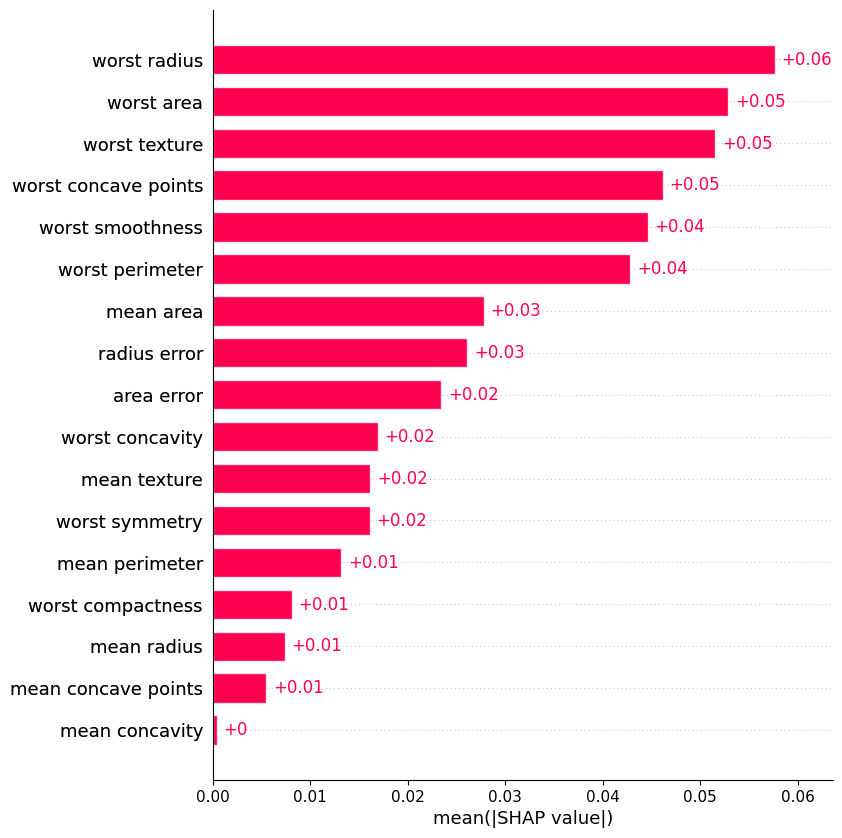

In [60]:
explanation = shap.Explanation(
    values=shap_values[:, :, 1],
    base_values=explainer.expected_value[1],
    data=X_test,
    feature_names=feature_names
)

num_features = len(feature_names)
plt.figure()
shap.plots.bar(explanation, max_display=num_features, show=True)
plt.close()

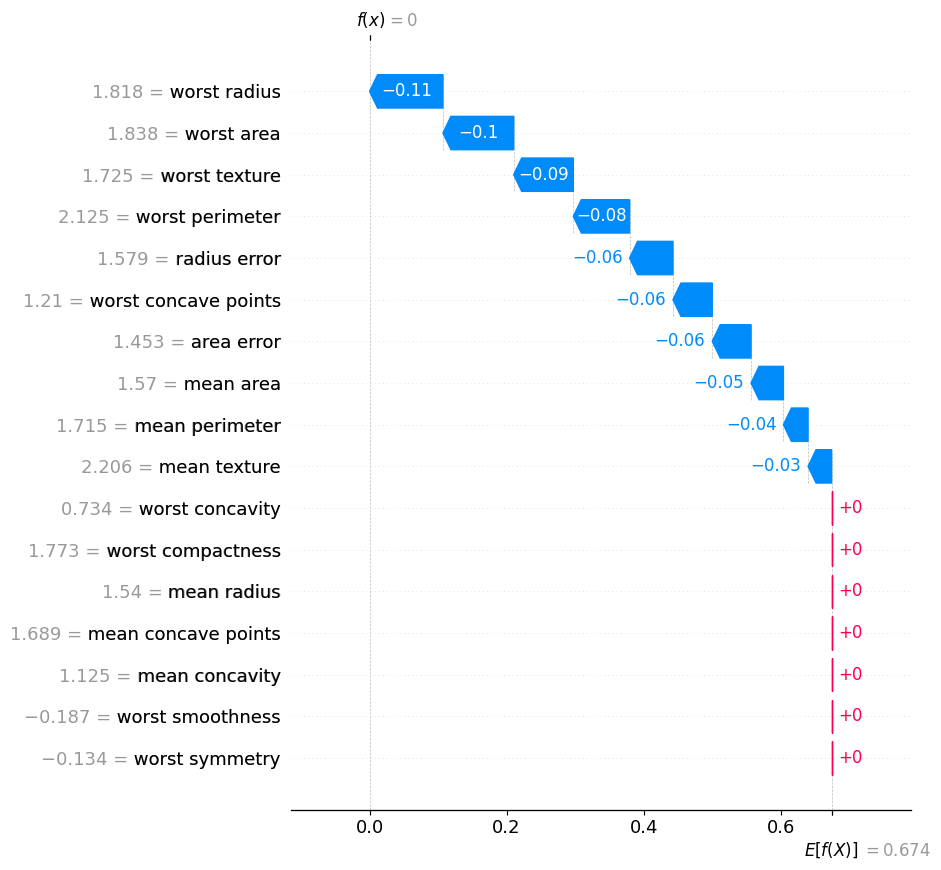

In [61]:
plt.figure()
shap.plots.waterfall(explanation[0], max_display=num_features, show=True)
plt.close()

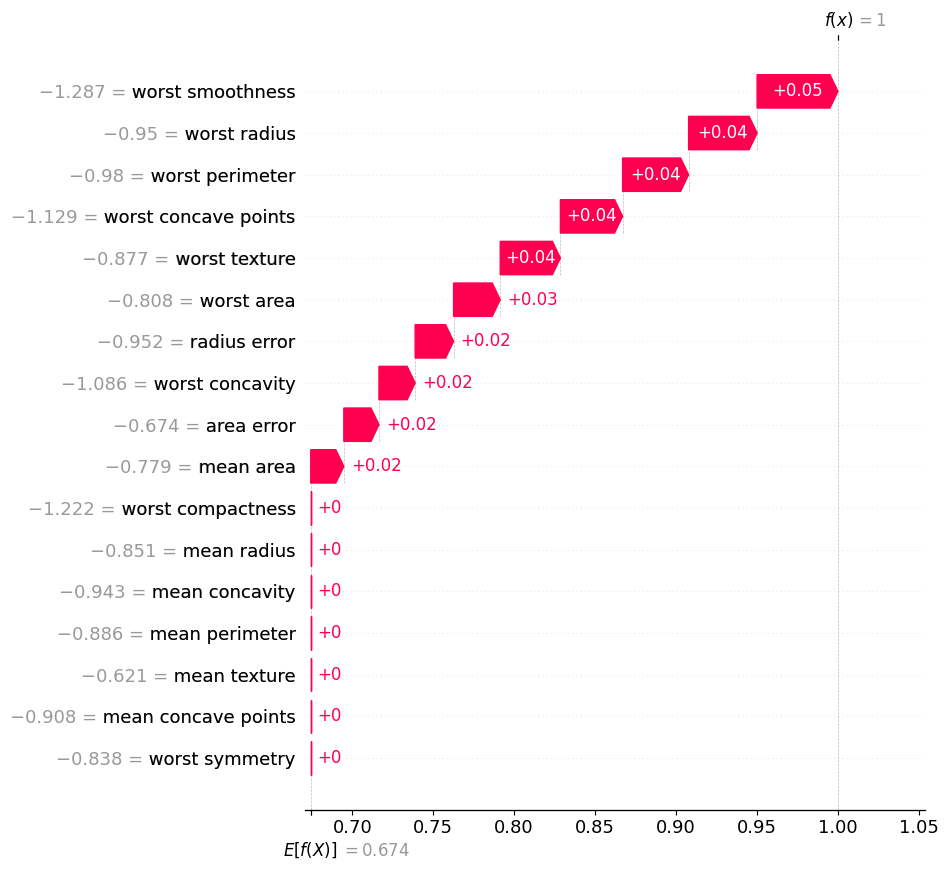

In [62]:
plt.figure()
shap.plots.waterfall(explanation[1], max_display=num_features, show=True)
plt.close()

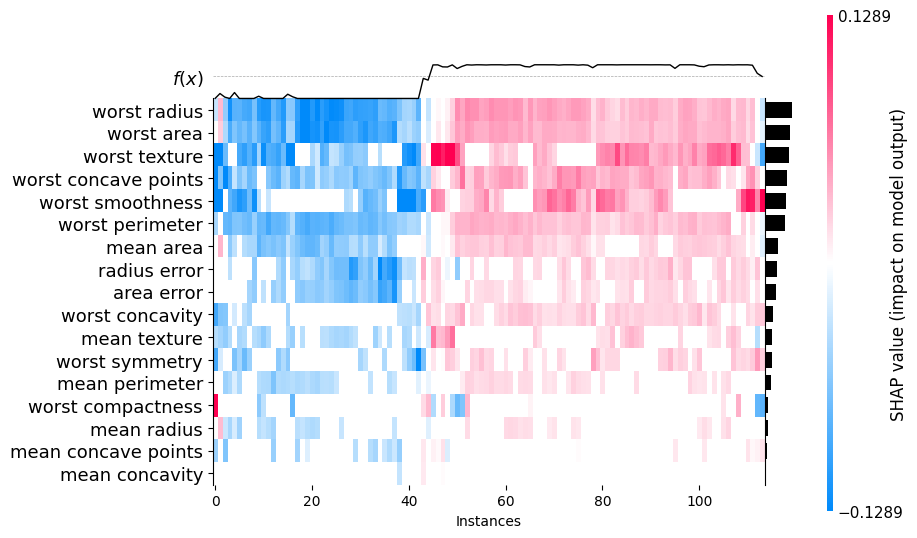

In [63]:
plt.figure()
shap.plots.heatmap(explanation, max_display=num_features, show=True)
plt.close()